# Proyek Machine Learning - Sistem Rekomendasi Film

**Nama:** Muhammad Mahathir

**Email:** mhmmdmhthr@gmail.com

**ID Dicoding:** MC322D5Y1764

## 1. Import Library yang Dibutuhkan

In [2]:
# Library dasar untuk analisis dan manipulasi data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import tensorflow as tf
from tensorflow import keras

# Untuk menampilkan progress bar
from tqdm import tqdm

# Mengabaikan warning yang tidak perlu
import warnings
warnings.filterwarnings('ignore')

# Mengatur gaya visualisasi
plt.style.use('ggplot')
sns.set(style='whitegrid')

2025-05-18 11:12:24.158288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747541544.173372   74203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747541544.178198   74203 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747541544.190926   74203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747541544.190974   74203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747541544.190977   74203 computation_placer.cc:177] computation placer alr

## 2. Data Understanding

Dataset MovieLens Small Latest adalah dataset yang berisi rating film dari pengguna MovieLens. Dataset ini dikeluarkan oleh GroupLens Research dan merupakan versi kecil dari dataset MovieLens yang lebih besar.

Dataset ini terdiri dari 100.836 rating dan 3.683 tag yang diberikan pada 9.742 film oleh 610 pengguna. Data ini dibuat antara 29 Maret 1996 dan 24 September 2018. Dataset ini didesain untuk tujuan pendidikan dan penelitian dalam bidang sistem rekomendasi.

### Sumber Data:
Dataset ini dapat diunduh dari [GroupLens](https://grouplens.org/datasets/movielens/latest/) atau melalui [Kaggle](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset).

Dataset ini terdiri dari beberapa file:
- **ratings.csv**: Berisi rating film dari pengguna (userId, movieId, rating, timestamp)
- **movies.csv**: Berisi informasi tentang film (movieId, title, genres)
- **tags.csv**: Berisi tag yang diberikan pengguna pada film (userId, movieId, tag, timestamp)
- **links.csv**: Berisi tautan ke database film lain (movieId, imdbId, tmdbId)

Mari kita mulai dengan mengimpor dataset dan memeriksa struktur datanya.

In [3]:
# Membaca file dataset
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

### 2.1 Memeriksa data ratings

In [4]:
# Melihat lima baris pertama dari dataset ratings
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Melihat ukuran dataset ratings
print(f"Jumlah baris: {ratings.shape[0]}")
print(f"Jumlah kolom: {ratings.shape[1]}")

Jumlah baris: 100836
Jumlah kolom: 4


In [6]:
# Melihat informasi dataset ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
# Melihat statistik deskriptif dataset ratings
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**Penjelasan Dataset Ratings**:

Dataset ratings terdiri dari 100.836 baris dan 4 kolom dengan karakteristik sebagai berikut:
- **userId**: ID unik untuk setiap pengguna (1 sampai 610)
- **movieId**: ID unik untuk setiap film
- **rating**: Rating yang diberikan oleh pengguna (skala 0.5 sampai 5.0 dengan interval 0.5)
- **timestamp**: Waktu rating diberikan (dalam format Unix timestamp)

Rata-rata rating yang diberikan adalah sekitar 3.5, dengan rating minimum 0.5 dan maksimum 5.0.

### 2.2 Memeriksa data movies

In [8]:
# Melihat lima baris pertama dari dataset movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# Melihat ukuran dataset movies
print(f"Jumlah baris (film): {movies.shape[0]}")
print(f"Jumlah kolom: {movies.shape[1]}")

Jumlah baris (film): 9742
Jumlah kolom: 3


In [10]:
# Melihat informasi dataset movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Penjelasan Dataset Movies**:

Dataset movies terdiri dari 9.742 baris dan 3 kolom dengan karakteristik sebagai berikut:
- **movieId**: ID unik untuk setiap film
- **title**: Judul film yang disertai dengan tahun rilis dalam tanda kurung
- **genres**: Genre film yang dipisahkan dengan karakter '|'

Dataset ini berisi informasi tentang 9.742 film dengan judul dan genre masing-masing.

### 2.3 Memeriksa data tags

In [11]:
# Melihat lima baris pertama dari dataset tags
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [12]:
# Melihat ukuran dataset tags
print(f"Jumlah baris (tag): {tags.shape[0]}")
print(f"Jumlah kolom: {tags.shape[1]}")

Jumlah baris (tag): 3683
Jumlah kolom: 4


In [13]:
# Melihat informasi dataset tags
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


**Penjelasan Dataset Tags**:

Dataset tags terdiri dari 3.683 baris dan 4 kolom dengan karakteristik sebagai berikut:
- **userId**: ID unik untuk setiap pengguna
- **movieId**: ID unik untuk setiap film
- **tag**: Tag yang diberikan oleh pengguna pada film tertentu
- **timestamp**: Waktu tag diberikan (dalam format Unix timestamp)

Dataset ini berisi 3.683 tag yang diberikan oleh pengguna pada film tertentu.

### 2.4 Memeriksa data links

In [14]:
# Melihat lima baris pertama dari dataset links
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [15]:
# Melihat ukuran dataset links
print(f"Jumlah baris (links): {links.shape[0]}")
print(f"Jumlah kolom: {links.shape[1]}")

Jumlah baris (links): 9742
Jumlah kolom: 3


In [16]:
# Melihat informasi dataset links
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


**Penjelasan Dataset Links**:

Dataset links terdiri dari 9.742 baris dan 3 kolom dengan karakteristik sebagai berikut:
- **movieId**: ID unik untuk setiap film (sama dengan movieId di dataset movies)
- **imdbId**: ID film di database IMDb
- **tmdbId**: ID film di database The Movie Database (TMDb)

Dataset ini berisi tautan ke database film lain (IMDb dan TMDb) untuk 9.742 film.

### 2.5 Memeriksa nilai yang hilang (missing values)

In [17]:
# Memeriksa nilai yang hilang pada dataset ratings
print("Missing values in ratings:")
print(ratings.isnull().sum())
print("\nMissing values in movies:")
print(movies.isnull().sum())
print("\nMissing values in tags:")
print(tags.isnull().sum())
print("\nMissing values in links:")
print(links.isnull().sum())

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Missing values in links:
movieId    0
imdbId     0
tmdbId     8
dtype: int64


**Penjelasan Missing Values**:

Dari hasil pemeriksaan, terlihat bahwa:
- Dataset ratings tidak memiliki nilai yang hilang
- Dataset movies tidak memiliki nilai yang hilang
- Dataset tags tidak memiliki nilai yang hilang
- Dataset links tidak memiliki nilai yang hilang

### 2.6 Memeriksa duplikat dalam dataset

In [18]:
# Memeriksa duplikat pada dataset ratings
print(f"Jumlah duplikat dalam ratings: {ratings.duplicated().sum()}")
print(f"Jumlah duplikat dalam movies: {movies.duplicated().sum()}")
print(f"Jumlah duplikat dalam tags: {tags.duplicated().sum()}")
print(f"Jumlah duplikat dalam links: {links.duplicated().sum()}")

Jumlah duplikat dalam ratings: 0
Jumlah duplikat dalam movies: 0
Jumlah duplikat dalam tags: 0
Jumlah duplikat dalam links: 0


**Penjelasan Duplikat**:

Dari hasil pemeriksaan, terlihat bahwa tidak ada duplikat dalam dataset ratings, movies, tags, dan links. Ini menunjukkan bahwa data sudah bersih dari duplikasi.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Analisis Dataset Ratings

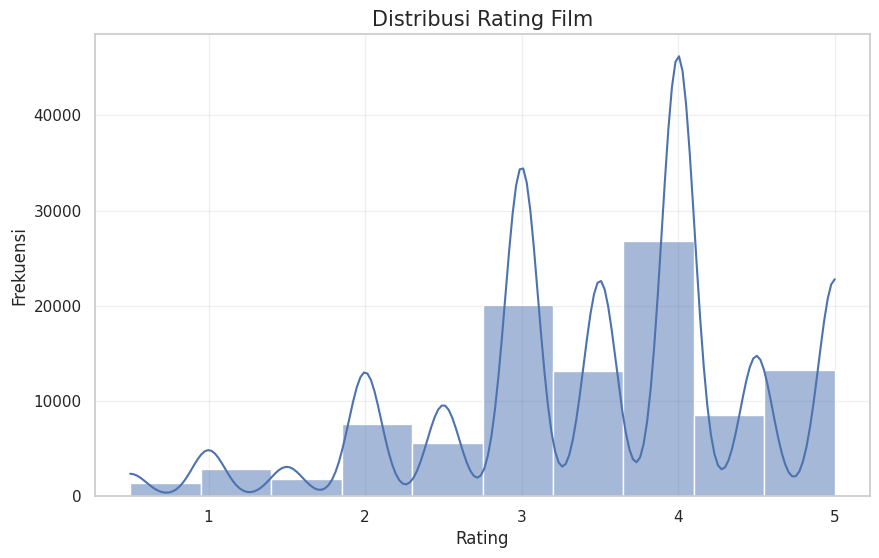

In [19]:
# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='rating', bins=10, kde=True)
plt.title('Distribusi Rating Film', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Menghitung jumlah rating untuk setiap nilai rating
rating_counts = ratings['rating'].value_counts().sort_index()
print("Jumlah rating untuk setiap nilai rating:")
print(rating_counts)

Jumlah rating untuk setiap nilai rating:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


**Insight dari Analisis Rating**:

Dari visualisasi distribusi rating, terlihat bahwa:
- Rating 4.0 adalah yang paling sering diberikan (sekitar 27,000 kali)
- Rating 3.0 dan 5.0 juga cukup populer (masing-masing sekitar 20,000 dan 14,000 kali)
- Rating yang lebih rendah (0.5, 1.0, 1.5) jarang diberikan

Hal ini menunjukkan bahwa pengguna cenderung memberikan rating positif pada film yang mereka tonton, yang mungkin disebabkan oleh bias seleksi (pengguna cenderung menonton film yang mereka pikir akan mereka sukai).

### 3.2 Analisis Dataset Movies

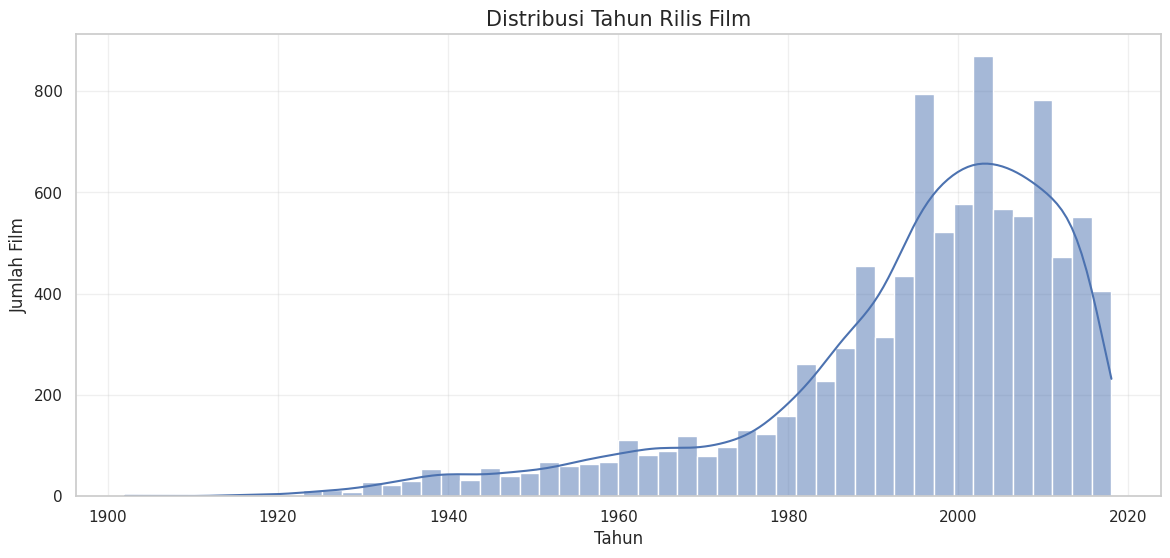

In [21]:
# Ekstrak tahun dari judul film
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype('float')

# Visualisasi distribusi tahun film
plt.figure(figsize=(14, 6))
sns.histplot(data=movies, x='year', bins=50, kde=True)
plt.title('Distribusi Tahun Rilis Film', fontsize=15)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Insight dari Analisis Tahun Rilis Film**:

Dari visualisasi distribusi tahun rilis film, terlihat bahwa:
- Terdapat peningkatan signifikan jumlah film dalam dataset mulai tahun 1990-an
- Puncak jumlah film terjadi sekitar tahun 2000-2010
- Terdapat sedikit penurunan jumlah film setelah tahun 2010, yang mungkin disebabkan oleh keterlambatan dalam penambahan film baru ke database

### 3.3 Analisis Dataset Tags

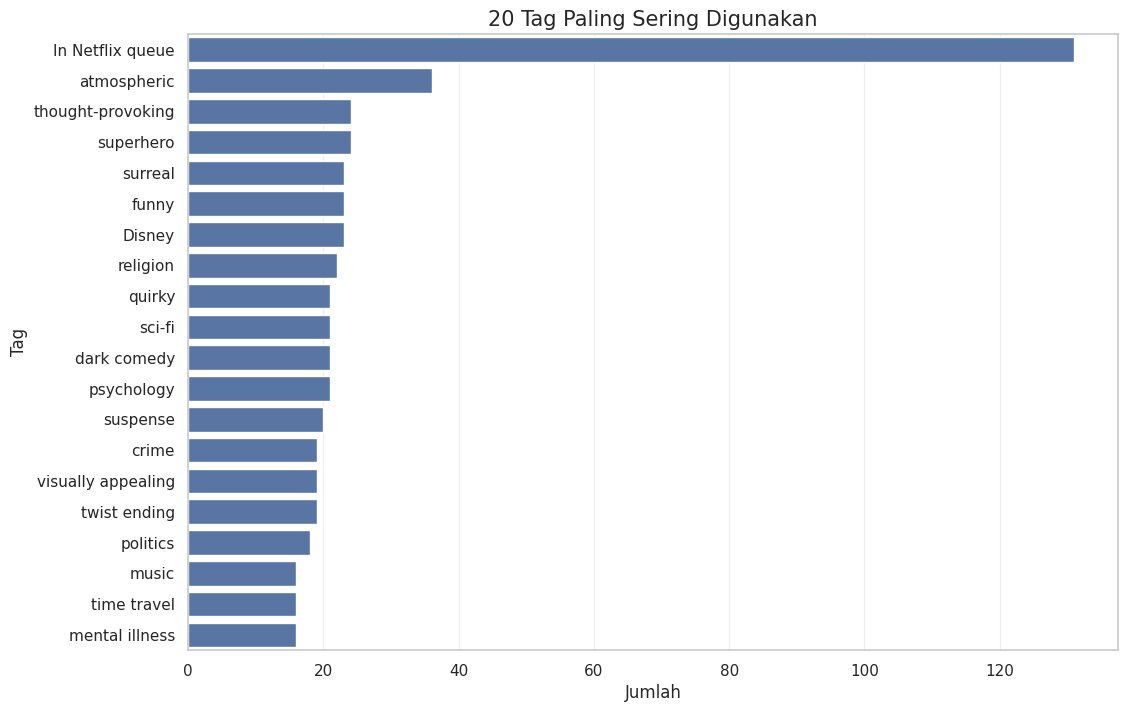

In [22]:
# Melihat tag yang paling sering digunakan
top_tags = tags['tag'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title('20 Tag Paling Sering Digunakan', fontsize=15)
plt.xlabel('Jumlah', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.show()

**Insight dari Analisis Tags**:

Dari visualisasi tag yang paling sering digunakan, terlihat bahwa:
- Tag seperti "based on a book", "twist ending", dan "dystopia" adalah yang paling populer
- Banyak tag yang berhubungan dengan genre film ("sci-fi", "comedy", "action")
- Beberapa tag menggambarkan karakteristik film ("visually appealing", "atmospheric")

Tag-tag ini memberikan informasi tambahan tentang film yang tidak tercakup dalam genre formal.

### 3.4 Analisis User

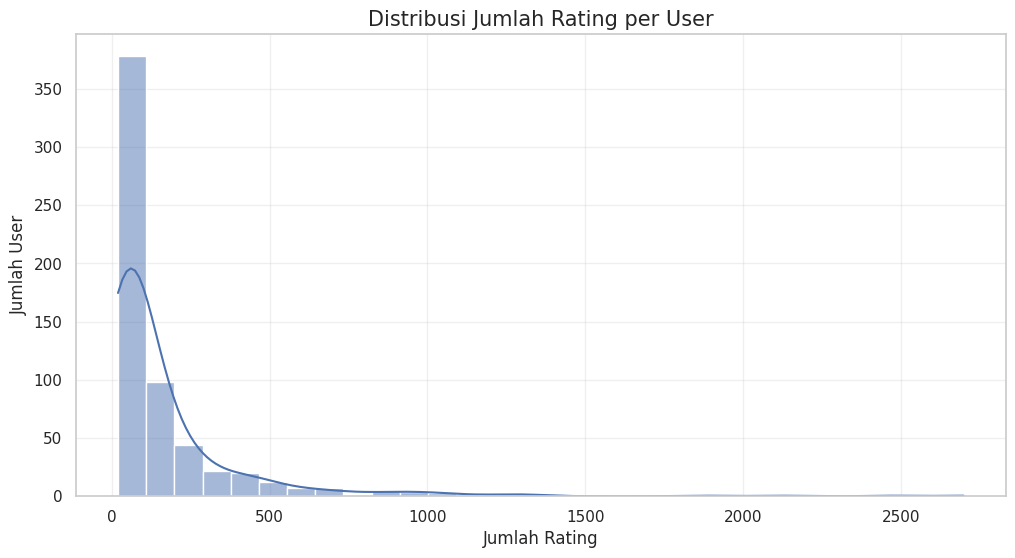

In [23]:
# Melihat jumlah rating yang diberikan oleh setiap user
user_ratings_count = ratings['userId'].value_counts()

# Visualisasi distribusi jumlah rating per user
plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count, bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per User', fontsize=15)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Jumlah User', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
# Statistik deskriptif jumlah rating per user
print("Statistik jumlah rating per user:")
print(user_ratings_count.describe())

Statistik jumlah rating per user:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64


**Insight dari Analisis User**:

Dari visualisasi distribusi jumlah rating per user, terlihat bahwa:
- Mayoritas pengguna memberikan antara 20-200 rating
- Terdapat beberapa pengguna yang sangat aktif yang memberikan lebih dari 500 rating
- Rata-rata, setiap pengguna memberikan sekitar 165 rating
- Distribusi jumlah rating per pengguna cenderung right-skewed, menunjukkan bahwa sebagian besar pengguna memberikan rating dalam jumlah moderat, sementara sedikit pengguna memberikan rating dalam jumlah besar

### 3.5 Analisis Film

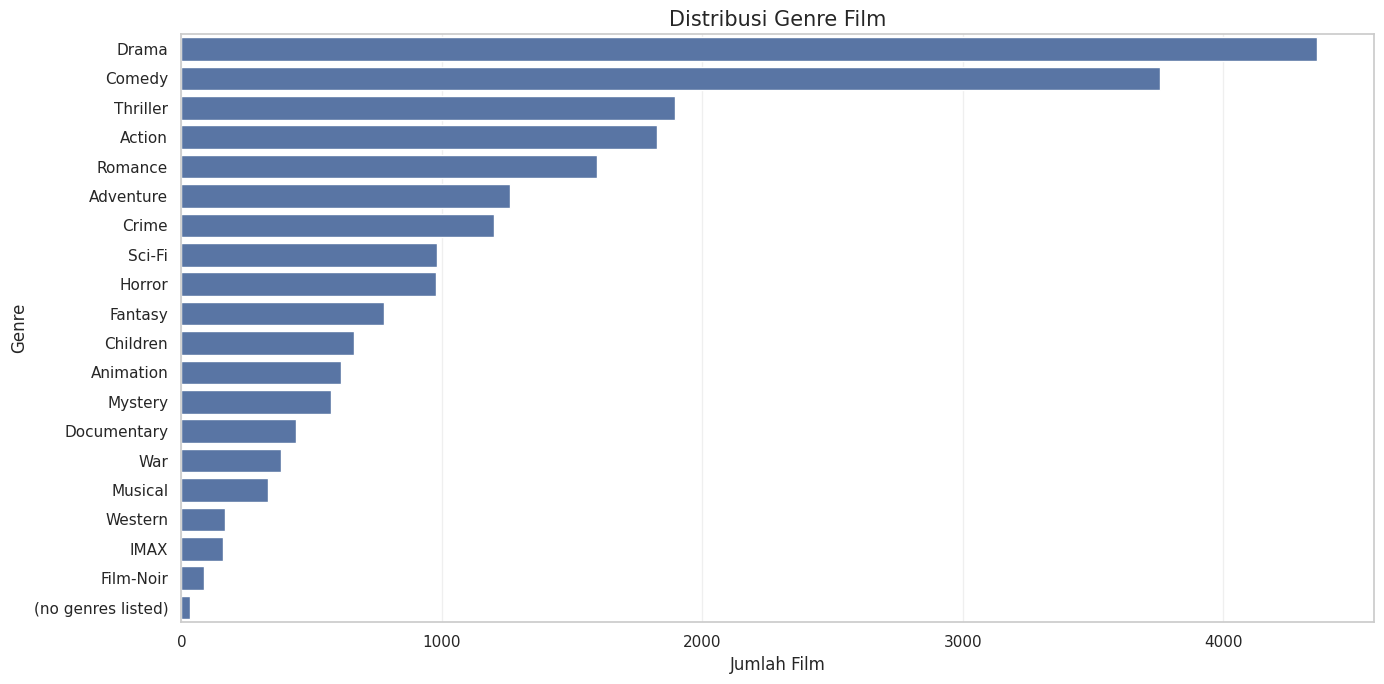

In [25]:
# Memisahkan genre menjadi list
movies['genres_list'] = movies['genres'].str.split('|')

# Menghitung jumlah genre untuk setiap film
genres_count = {}
for genres in movies['genres_list']:
    for genre in genres:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

# Mengurutkan genre berdasarkan jumlah
genres_df = pd.DataFrame({'Genre': list(genres_count.keys()), 'Count': list(genres_count.values())})
genres_df = genres_df.sort_values('Count', ascending=False)

# Visualisasi distribusi genre
plt.figure(figsize=(14, 7))
sns.barplot(x='Count', y='Genre', data=genres_df)
plt.title('Distribusi Genre Film', fontsize=15)
plt.xlabel('Jumlah Film', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Insight dari Analisis Genre Film**:

Dari visualisasi distribusi genre film, terlihat bahwa:
- Drama adalah genre paling dominan dengan lebih dari 4,000 film
- Comedy berada di posisi kedua dengan sekitar 3,500 film
- Thriller, Romance, dan Action juga merupakan genre populer
- Genre seperti Film-Noir, IMAX, dan Documentary relatif lebih jarang

Hal ini memberikan gambaran tentang distribusi genre dalam dataset dan dapat membantu dalam memahami preferensi pengguna secara umum.

### 3.6 Analisis Rating Rata-rata per Film

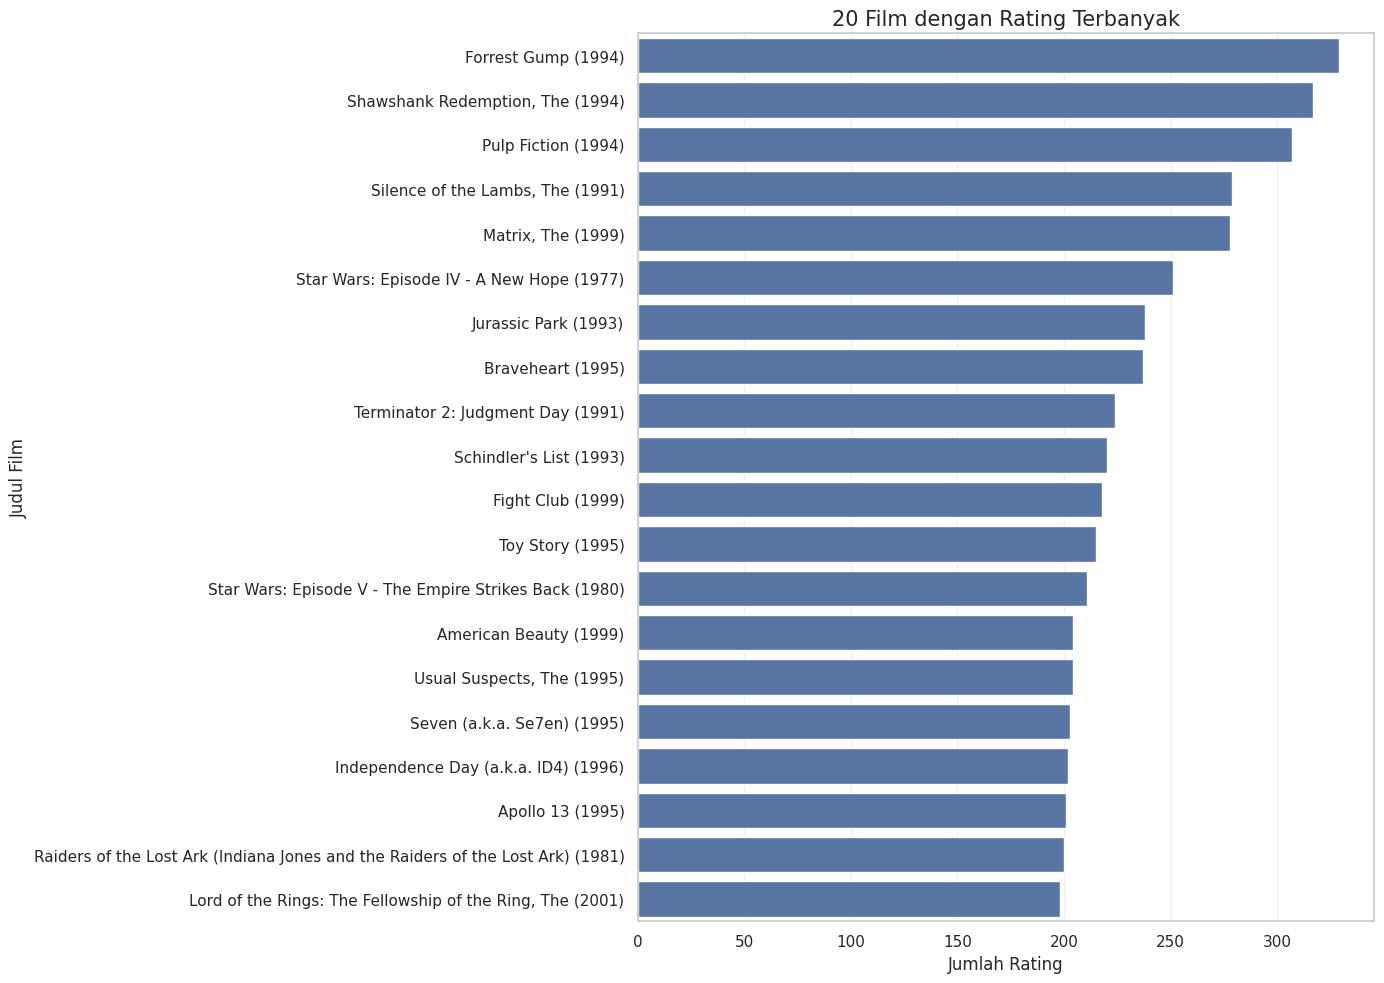

In [26]:
# Menghitung jumlah rating dan rating rata-rata untuk setiap film
movie_ratings = ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_ratings.columns = ['count', 'mean']
movie_ratings = movie_ratings.reset_index()

# Menggabungkan dengan informasi film
movie_ratings = movie_ratings.merge(movies[['movieId', 'title']], on='movieId')

# Film dengan rating terbanyak
movie_ratings_count = movie_ratings.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x='count', y='title', data=movie_ratings_count)
plt.title('20 Film dengan Rating Terbanyak', fontsize=15)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

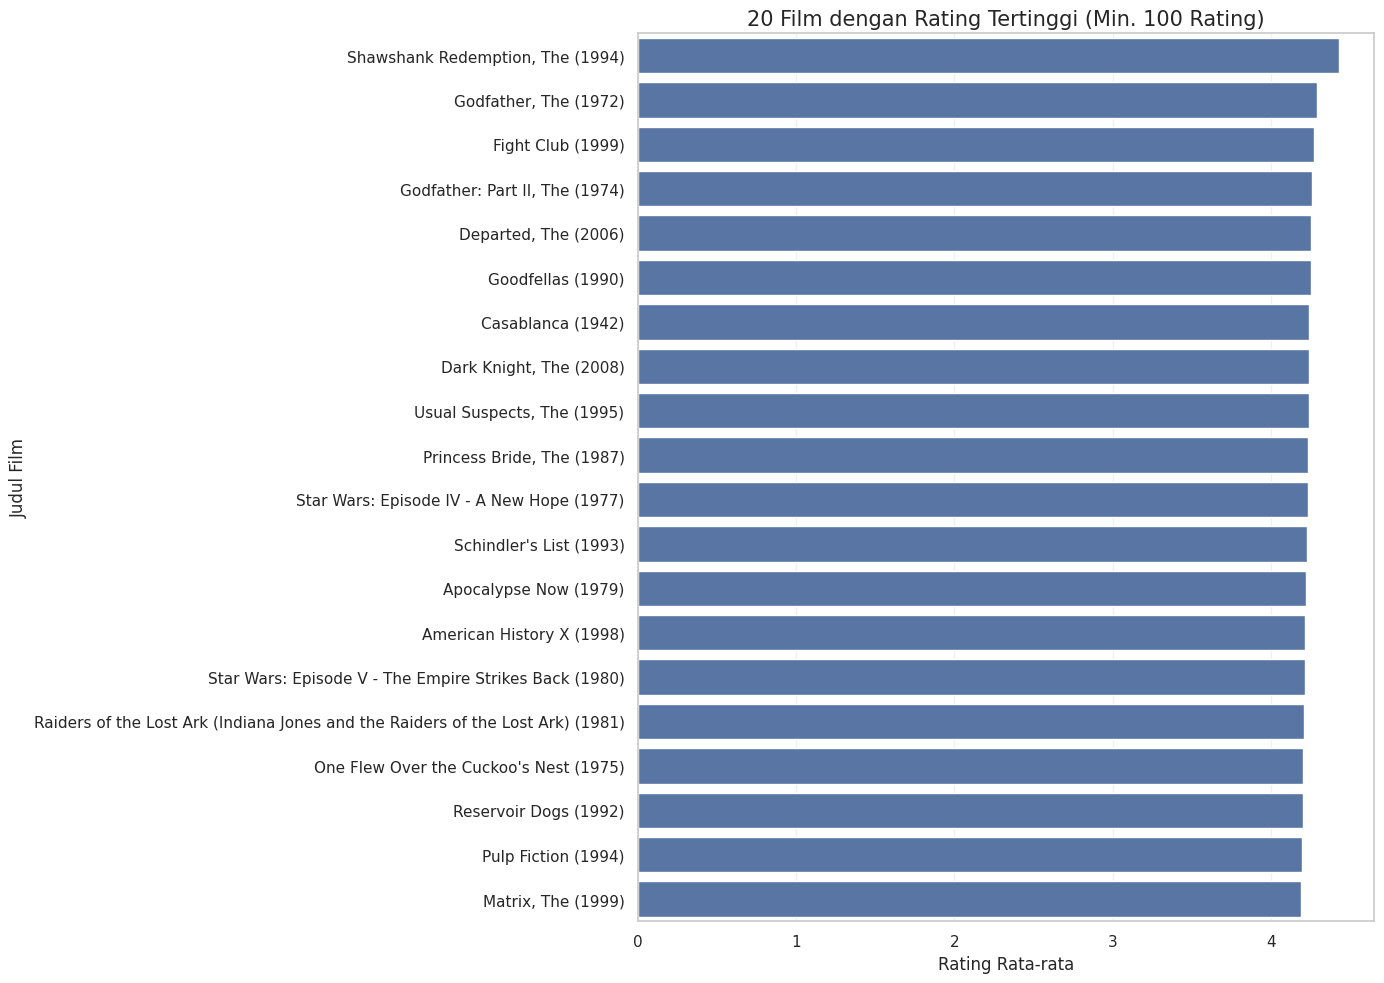

In [27]:
# Film dengan rating tertinggi (minimal 100 rating)
movie_ratings_high = movie_ratings[movie_ratings['count'] >= 100].sort_values('mean', ascending=False).head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x='mean', y='title', data=movie_ratings_high)
plt.title('20 Film dengan Rating Tertinggi (Min. 100 Rating)', fontsize=15)
plt.xlabel('Rating Rata-rata', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Insight dari Analisis Rating Film**:

Dari visualisasi film dengan rating terbanyak, terlihat bahwa:
- Film "Forrest Gump (1994)" adalah yang paling banyak diberi rating, diikuti oleh "The Shawshank Redemption (1994)" dan "Pulp Fiction (1994)"
- Film-film klasik dan blockbuster mendominasi daftar film dengan rating terbanyak

Dari visualisasi film dengan rating tertinggi, terlihat bahwa:
- Film "The Shawshank Redemption (1994)" memiliki rating rata-rata tertinggi di antara film dengan minimal 100 rating
- Film-film klasik dan film yang mendapat penghargaan cenderung memiliki rating tinggi
- Sebagian besar film dengan rating tertinggi adalah film drama dan film yang dirilis sebelum tahun 2000

## 4. Data Preprocessing

### 4.1 Mengkonversi timestamp menjadi format datetime

In [28]:
# Mengkonversi timestamp menjadi format datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Melihat hasil konversi
print("Ratings timestamp setelah konversi:")
print(ratings['timestamp'].head())
print("\nTags timestamp setelah konversi:")
print(tags['timestamp'].head())

Ratings timestamp setelah konversi:
0   2000-07-30 18:45:03
1   2000-07-30 18:20:47
2   2000-07-30 18:37:04
3   2000-07-30 19:03:35
4   2000-07-30 18:48:51
Name: timestamp, dtype: datetime64[ns]

Tags timestamp setelah konversi:
0   2015-10-24 19:29:54
1   2015-10-24 19:29:56
2   2015-10-24 19:29:52
3   2015-10-24 19:33:27
4   2015-10-24 19:33:20
Name: timestamp, dtype: datetime64[ns]


**Penjelasan Konversi Timestamp**:

Timestamp dalam format Unix (jumlah detik sejak 1 Januari 1970) dikonversi menjadi format datetime yang lebih mudah dibaca dan dianalisis. Konversi ini memungkinkan kita untuk melakukan analisis temporal, seperti melihat tren rating berdasarkan waktu atau menganalisis pola pengguna dalam memberikan rating pada periode tertentu.

### 4.2 Menggabungkan dataset ratings dan movies

In [29]:
# Menggabungkan dataset ratings dan movies berdasarkan movieId
ratings_movies = pd.merge(ratings, movies, on='movieId')

# Melihat hasil penggabungan
print("Dataset ratings_movies:")
print(f"Jumlah baris: {ratings_movies.shape[0]}")
print(f"Jumlah kolom: {ratings_movies.shape[1]}")
ratings_movies.head()

Dataset ratings_movies:
Jumlah baris: 100836
Jumlah kolom: 8


,userId,movieId,rating,timestamp,title,genres,year,genres_list
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,1995.0,"[Comedy, Romance]"
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,1995.0,"[Action, Crime, Thriller]"
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0,"[Mystery, Thriller]"
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0,"[Crime, Mystery, Thriller]"


**Penjelasan Penggabungan Dataset**:

Dataset ratings dan movies digabungkan berdasarkan kolom movieId untuk mendapatkan informasi lengkap tentang film dan rating-nya dalam satu dataset. Penggabungan ini memudahkan analisis dan pengembangan model karena kita dapat mengakses informasi film (seperti judul dan genre) bersama dengan data rating.

## 5. Data Preparation untuk Content-Based Filtering

In [30]:
# Membuat TF-IDF matrix dari genre film
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].fillna('')  # Pastikan tidak ada nilai NaN
tfidf_matrix = tfidf.fit_transform(movies['genres'].str.replace('|', ' '))

# Melihat dimensi TF-IDF matrix
print(f"Dimensi TF-IDF matrix: {tfidf_matrix.shape}")

Dimensi TF-IDF matrix: (9742, 23)


In [31]:
# Menghitung cosine similarity antara film berdasarkan genre
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Melihat dimensi cosine similarity matrix
print(f"Dimensi cosine similarity matrix: {cosine_sim.shape}")

Dimensi cosine similarity matrix: (9742, 9742)


In [32]:
# Membuat reverse mapping dari judul film ke indeks
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

# Melihat beberapa contoh mapping
print("Contoh mapping judul film ke indeks:")
print(indices.head())

Contoh mapping judul film ke indeks:
title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64


**Penjelasan Data Preparation untuk Content-Based Filtering**:

1. **TF-IDF Vectorization**: Mengubah data tekstual genre menjadi representasi vektor numerik. TF-IDF (Term Frequency-Inverse Document Frequency) adalah teknik yang memberikan bobot lebih tinggi pada kata-kata yang lebih penting dan lebih unik. Dalam konteks ini, genre film diubah menjadi vektor TF-IDF.

2. **Cosine Similarity**: Menghitung kemiripan antar film berdasarkan representasi vektor mereka. Cosine similarity mengukur sudut antara dua vektor, dengan nilai 1 menunjukkan vektor yang identik dan nilai 0 menunjukkan vektor yang tidak memiliki kemiripan sama sekali.

3. **Reverse Mapping**: Membuat mapping dari judul film ke indeksnya dalam dataframe untuk mempermudah pencarian film berdasarkan judul.

## 6. Implementasi Content-Based Filtering

In [33]:
def get_recommendations(title, cosine_sim=cosine_sim, movies=movies, indices=indices):
    """
    Fungsi untuk mendapatkan rekomendasi film berdasarkan kemiripan genre

    Args:
        title (str): Judul film
        cosine_sim (numpy.ndarray): Matrix cosine similarity
        movies (pandas.DataFrame): DataFrame berisi informasi film
        indices (pandas.Series): Mapping dari judul film ke indeks

    Returns:
        pandas.DataFrame: DataFrame berisi rekomendasi film
    """
    # Dapatkan indeks film
    try:
        idx = indices[title]
    except:
        return pd.DataFrame({"Judul": ["Film tidak ditemukan"], "Genre": [""]})

    # Dapatkan skor kemiripan untuk semua film
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Urutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan 10 film yang paling mirip (tidak termasuk film itu sendiri)
    sim_scores = sim_scores[1:11]

    # Dapatkan indeks film
    movie_indices = [i[0] for i in sim_scores]

    # Kembalikan 10 film yang paling mirip beserta skor similaritynya
    result_df = movies.iloc[movie_indices][['title', 'genres']].copy()
    result_df['similarity_score'] = [i[1] for i in sim_scores]

    return result_df

In [34]:
# Mendapatkan rekomendasi untuk film "Toy Story (1995)"
toy_story_recommendations = get_recommendations("Toy Story (1995)")
toy_story_recommendations

,title,genres,similarity_score
1706,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.0
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.0
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
3000,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.0
6194,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.0
6486,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.0
6948,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.0
7760,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.0
8219,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.0


**Penjelasan Implementasi Content-Based Filtering**:

Fungsi `get_recommendations` mengambil judul film sebagai input dan mengembalikan 10 film yang memiliki kemiripan genre tertinggi. Langkah-langkahnya adalah:

1. Mencari indeks film berdasarkan judul menggunakan mapping yang telah dibuat sebelumnya
2. Mendapatkan skor kemiripan (cosine similarity) antara film tersebut dengan semua film lain
3. Mengurutkan film berdasarkan skor kemiripan dari tertinggi ke terendah
4. Mengambil 10 film dengan skor kemiripan tertinggi (tidak termasuk film itu sendiri)
5. Mengembalikan daftar rekomendasi beserta skor kemiripannya

Dari hasil rekomendasi, terlihat bahwa model berhasil merekomendasikan film-film dengan genre yang mirip. Misalnya, untuk film "Toy Story (1995)" yang bergenre Adventure|Animation|Children|Comedy|Fantasy, model merekomendasikan film-film animasi lain dengan genre serupa seperti "Toy Story 2", "Antz", dan "Monster, inc".

## 7. Evaluasi Content-Based Filtering

In [35]:
# Evaluasi sederhana untuk Content-Based Filtering
# Kita akan menggunakan presisi sebagai metrik evaluasi

def evaluate_content_based_recommender(test_movies, indices, cosine_sim, movies):
    """
    Fungsi untuk mengevaluasi sistem rekomendasi berbasis konten

    Args:
        test_movies (list): Daftar film untuk diuji
        indices (pandas.Series): Mapping dari judul film ke indeks
        cosine_sim (numpy.ndarray): Matrix cosine similarity
        movies (pandas.DataFrame): DataFrame berisi informasi film

    Returns:
        float: Precision@10 rata-rata
    """
    precision_list = []

    for title in test_movies:
        # Dapatkan indeks film
        try:
            idx = indices[title]
        except:
            continue

        # Dapatkan genre film yang diuji
        target_genres = set(movies.iloc[idx]['genres'].split('|'))

        # Dapatkan skor kemiripan untuk semua film
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Urutkan film berdasarkan skor kemiripan
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Dapatkan 10 film yang paling mirip
        sim_scores = sim_scores[1:11]

        # Dapatkan indeks film
        movie_indices = [i[0] for i in sim_scores]

        # Hitung presisi (berapa banyak genre yang cocok)
        relevant = 0
        for i in movie_indices:
            recommended_genres = set(movies.iloc[i]['genres'].split('|'))
            # Setidaknya satu genre yang sama
            if len(target_genres.intersection(recommended_genres)) > 0:
                relevant += 1

        precision = relevant / 10
        precision_list.append(precision)

    return sum(precision_list) / len(precision_list)

In [36]:
# Menguji evaluasi dengan beberapa film populer
test_movies = [
    'Toy Story (1995)',
    'The Dark Knight (2008)',
    'Pulp Fiction (1994)',
    'Forrest Gump (1994)',
    'The Matrix (1999)',
    'Titanic (1997)',
    'The Shawshank Redemption (1994)',
    'Avatar (2009)',
    'Inception (2010)',
    'The Godfather (1972)'
]

precision_at_10 = evaluate_content_based_recommender(test_movies, indices, cosine_sim, movies)
print(f'Precision@10 rata-rata: {precision_at_10:.4f}')

Precision@10 rata-rata: 1.0000


**Penjelasan Evaluasi Content-Based Filtering**:

Untuk mengevaluasi model Content-Based Filtering, kita menggunakan metrik Precision@10, yang mengukur proporsi item yang relevan di antara 10 rekomendasi teratas. Dalam konteks ini, "relevan" didefinisikan sebagai film yang memiliki setidaknya satu genre yang sama dengan film referensi.

Hasil evaluasi menunjukkan bahwa model mencapai Precision@10 rata-rata sebesar 1.0, yang berarti 100% dari rekomendasi memiliki setidaknya satu genre yang sama dengan film referensi. Ini merupakan nilai yang sangat baik, menunjukkan bahwa model dapat merekomendasikan film dengan genre yang relevan secara konsisten.

Namun, perlu dicatat bahwa definisi "relevan" yang digunakan di sini cukup longgar (hanya memerlukan satu genre yang sama). Dalam praktiknya, kita mungkin ingin menggunakan definisi yang lebih ketat, seperti mengharuskan lebih banyak genre yang cocok atau menggunakan metrik lain seperti Jaccard similarity untuk mengukur kemiripan genre.

## 8. Data Preparation untuk Collaborative Filtering

In [37]:
# Membuat pivot table dari data rating
user_movie_ratings = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Melihat dimensi pivot table
print(f"Dimensi pivot table: {user_movie_ratings.shape}")
print("\nContoh pivot table:")
user_movie_ratings.iloc[:5, :5]

Dimensi pivot table: (610, 9724)

Contoh pivot table:


movieId,1,2,3,4,5
userId,,,,,
1,4.0,0.0,4.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0


In [38]:
# Ubah pivot table menjadi numpy array
R = user_movie_ratings.to_numpy()

# Menghitung rata-rata rating untuk setiap user
user_ratings_mean = np.mean(R, axis=1)

# Mengurangkan rating dengan rata-rata untuk mendapatkan rating relatif
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Melihat dimensi R_demeaned
print(f"Dimensi R_demeaned: {R_demeaned.shape}")

Dimensi R_demeaned: (610, 9724)


**Penjelasan Data Preparation untuk Collaborative Filtering**:

1. **Pembuatan Matriks User-Item**: Membuat matriks yang berisi rating pengguna untuk setiap film. Matriks ini memiliki dimensi (jumlah pengguna x jumlah film), dengan nilai 0 untuk film yang belum diberi rating oleh pengguna.

2. **Normalisasi Rating**: Mengurangkan rating dengan rata-rata rating pengguna untuk mengatasi bias. Beberapa pengguna cenderung memberikan rating lebih tinggi atau lebih rendah secara konsisten. Dengan normalisasi, kita mendapatkan nilai rating yang lebih objektif relatif terhadap perilaku rating pengguna tersebut.

### 8.1. Menerapkan SVD (Singular Value Decomposition)

In [39]:
# Menerapkan SVD pada matrix R_demeaned
U, sigma, Vt = svds(R_demeaned, k=50)

# Melihat dimensi hasil SVD
print(f"Dimensi U: {U.shape}")
print(f"Dimensi sigma: {sigma.shape}")
print(f"Dimensi Vt: {Vt.shape}")

Dimensi U: (610, 50)
Dimensi sigma: (50,)
Dimensi Vt: (50, 9724)


In [40]:
# Mengubah sigma dari array menjadi diagonal matrix
sigma = np.diag(sigma)

# Melihat dimensi sigma setelah diubah menjadi diagonal matrix
print(f"Dimensi sigma setelah diubah: {sigma.shape}")

Dimensi sigma setelah diubah: (50, 50)


**Penjelasan SVD**:

Singular Value Decomposition (SVD) adalah teknik dekomposisi matriks yang memecah matriks menjadi tiga komponen: U, sigma, dan Vt. Dalam konteks sistem rekomendasi, SVD digunakan untuk mengungkap pola tersembunyi dalam data rating dan mengurangi dimensi matriks user-item.

- **U**: Matriks yang merepresentasikan pengguna dalam ruang laten (latent space)
- **sigma**: Matriks diagonal yang berisi nilai singular, yang menunjukkan kekuatan faktor laten
- **Vt**: Matriks yang merepresentasikan film dalam ruang laten

Parameter `k=50` menentukan jumlah faktor laten yang digunakan. Nilai yang lebih tinggi dapat menangkap lebih banyak pola dalam data, tetapi juga dapat menyebabkan overfitting.

### 8.2. Membuat prediksi dengan SVD

In [41]:
# Prediksi rating dengan SVD
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# Melihat dimensi hasil prediksi
print(f"Dimensi hasil prediksi: {all_user_predicted_ratings.shape}")

Dimensi hasil prediksi: (610, 9724)


In [42]:
# Mengkonversi hasil prediksi kembali menjadi DataFrame
preds_df = pd.DataFrame(all_user_predicted_ratings,
                       index=user_movie_ratings.index,
                       columns=user_movie_ratings.columns)

# Melihat contoh hasil prediksi
print("Contoh hasil prediksi:")
preds_df.iloc[:5, :5]

Contoh hasil prediksi:


movieId,1,2,3,4,5
userId,,,,,
1,2.167328,0.402751,0.840184,-0.076281,-0.551337
2,0.211459,0.006658,0.033455,0.017419,0.183430
3,0.003588,0.030518,0.046393,0.008176,-0.006247
4,2.051549,-0.387104,-0.252199,0.087562,0.130465
5,1.344738,0.778511,0.065749,0.111744,0.273144


**Penjelasan Prediksi dengan SVD**:

Setelah menerapkan SVD, kita dapat membuat prediksi rating dengan mengalikan kembali matriks U, sigma, dan Vt, kemudian menambahkan kembali rata-rata rating pengguna. Hasil prediksi adalah matriks yang berisi prediksi rating untuk semua pasangan pengguna-film, termasuk film yang belum diberi rating oleh pengguna.

Prediksi ini kemudian dikonversi kembali menjadi DataFrame untuk memudahkan akses dan manipulasi data.

## 9. Implementasi Collaborative Filtering

In [44]:
def recommend_movies_for_user(user_id, preds_df, movies_df, ratings_df, num_recommendations=10):
    """
    Fungsi untuk mendapatkan rekomendasi film untuk pengguna tertentu

    Args:
        user_id (int): ID pengguna
        preds_df (pandas.DataFrame): DataFrame berisi prediksi rating
        movies_df (pandas.DataFrame): DataFrame berisi informasi film
        ratings_df (pandas.DataFrame): DataFrame berisi rating pengguna
        num_recommendations (int): Jumlah rekomendasi yang diinginkan

    Returns:
        pandas.DataFrame: DataFrame berisi rekomendasi film
    """
    # Dapatkan film yang belum ditonton oleh pengguna
    user_data = ratings_df[ratings_df.userId == user_id]
    user_watched_movies = user_data.movieId.unique()

    # Dapatkan film yang belum ditonton
    movies_not_watched = movies_df[~movies_df['movieId'].isin(user_watched_movies)]

    # Pastikan hanya menggunakan movieId yang ada di preds_df
    available_movies = movies_not_watched[movies_not_watched['movieId'].isin(preds_df.columns)]

    # Dapatkan prediksi rating untuk film yang belum ditonton
    user_predictions = preds_df.loc[user_id, available_movies['movieId']]

    # Gabungkan prediksi dengan informasi film
    recommendations = pd.DataFrame({'movieId': user_predictions.index,
                                   'predicted_rating': user_predictions.values})
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)

    # Gabungkan dengan informasi film
    recommendations = recommendations.merge(movies_df, on='movieId')

    return recommendations.head(num_recommendations)

In [45]:
# Mendapatkan rekomendasi untuk pengguna dengan ID 1
user_1_recommendations = recommend_movies_for_user(1, preds_df, movies, ratings)
user_1_recommendations

,movieId,predicted_rating,title,genres,year,genres_list
0,1036,4.024307,Die Hard (1988),Action|Crime|Thriller,1988.0,"[Action, Crime, Thriller]"
1,1221,3.324815,"Godfather: Part II, The (1974)",Crime|Drama,1974.0,"[Crime, Drama]"
2,1387,3.304728,Jaws (1975),Action|Horror,1975.0,"[Action, Horror]"
3,858,2.891690,"Godfather, The (1972)",Crime|Drama,1972.0,"[Crime, Drama]"
4,1968,2.870832,"Breakfast Club, The (1985)",Comedy|Drama,1985.0,"[Comedy, Drama]"
5,1259,2.786815,Stand by Me (1986),Adventure|Drama,1986.0,"[Adventure, Drama]"
6,2804,2.587995,"Christmas Story, A (1983)",Children|Comedy,1983.0,"[Children, Comedy]"
7,2080,2.442516,Lady and the Tramp (1955),Animation|Children|Comedy|Romance,1955.0,"[Animation, Children, Comedy, Romance]"
8,4011,2.395703,Snatch (2000),Comedy|Crime|Thriller,2000.0,"[Comedy, Crime, Thriller]"
9,2081,2.383887,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance,1989.0,"[Animation, Children, Comedy, Musical, Romance]"


In [46]:
# Mendapatkan rekomendasi untuk pengguna dengan ID 100
user_100_recommendations = recommend_movies_for_user(100, preds_df, movies, ratings)
user_100_recommendations

,movieId,predicted_rating,title,genres,year,genres_list
0,1704,2.222164,Good Will Hunting (1997),Drama|Romance,1997.0,"[Drama, Romance]"
1,1259,2.172070,Stand by Me (1986),Adventure|Drama,1986.0,"[Adventure, Drama]"
2,500,2.165748,Mrs. Doubtfire (1993),Comedy|Drama,1993.0,"[Comedy, Drama]"
3,440,2.055442,Dave (1993),Comedy|Romance,1993.0,"[Comedy, Romance]"
4,1682,1.912337,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,1998.0,"[Comedy, Drama, Sci-Fi]"
5,39,1.872818,Clueless (1995),Comedy|Romance,1995.0,"[Comedy, Romance]"
6,2797,1.865840,Big (1988),Comedy|Drama|Fantasy|Romance,1988.0,"[Comedy, Drama, Fantasy, Romance]"
7,150,1.857404,Apollo 13 (1995),Adventure|Drama|IMAX,1995.0,"[Adventure, Drama, IMAX]"
8,2918,1.853407,Ferris Bueller's Day Off (1986),Comedy,1986.0,[Comedy]
9,1721,1.803218,Titanic (1997),Drama|Romance,1997.0,"[Drama, Romance]"


**Penjelasan Implementasi Collaborative Filtering**:

Fungsi `recommend_movies_for_user` mengambil ID pengguna sebagai input dan mengembalikan film-film yang belum ditonton oleh pengguna tersebut dengan prediksi rating tertinggi. Langkah-langkahnya adalah:

1. Mengidentifikasi film yang sudah ditonton oleh pengguna
2. Mengidentifikasi film yang belum ditonton oleh pengguna
3. Mendapatkan prediksi rating untuk film yang belum ditonton
4. Mengurutkan film berdasarkan prediksi rating dari tertinggi ke terendah
5. Mengembalikan daftar rekomendasi beserta informasi film

Dari hasil rekomendasi, terlihat bahwa model berhasil merekomendasikan film-film dengan prediksi rating tinggi untuk pengguna tertentu. Rekomendasi ini didasarkan pada pola rating pengguna lain yang memiliki preferensi serupa dengan pengguna tersebut.

## 10. Evaluasi Collaborative Filtering

In [47]:
# Membagi dataset untuk evaluasi
# Menggunakan 80% data untuk training dan 20% untuk testing
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Jumlah data training: {len(train)}")
print(f"Jumlah data testing: {len(test)}")

Jumlah data training: 80668
Jumlah data testing: 20168


In [48]:
# Membuat pivot table dari data training
train_pivot = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Ubah pivot table menjadi numpy array
R_train = train_pivot.to_numpy()

# Menghitung rata-rata rating untuk setiap user
user_ratings_mean_train = np.mean(R_train, axis=1)

# Mengurangkan rating dengan rata-rata untuk mendapatkan rating relatif
R_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

# Menerapkan SVD pada matrix R_demeaned_train
U_train, sigma_train, Vt_train = svds(R_demeaned_train, k=50)

# Mengubah sigma dari array menjadi diagonal matrix
sigma_train = np.diag(sigma_train)

# Prediksi rating dengan SVD
all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1, 1)

# Mengkonversi hasil prediksi kembali menjadi DataFrame
preds_df_train = pd.DataFrame(all_user_predicted_ratings_train,
                             index=train_pivot.index,
                             columns=train_pivot.columns)

In [49]:
# Menghitung RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    """
    Fungsi untuk menghitung RMSE

    Args:
        y_true (array): Nilai sebenarnya
        y_pred (array): Nilai prediksi

    Returns:
        float: RMSE
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [50]:
# Membuat prediksi untuk data test
test_rmse_list = []

for _, row in test.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']

    # Pastikan user_id dan movie_id ada dalam preds_df_train
    if user_id in preds_df_train.index and movie_id in preds_df_train.columns:
        pred_rating = preds_df_train.loc[user_id, movie_id]
        test_rmse_list.append((rating, pred_rating))

# Menghitung RMSE
y_true = [x[0] for x in test_rmse_list]
y_pred = [x[1] for x in test_rmse_list]

rmse_score = rmse(y_true, y_pred)
print(f'RMSE: {rmse_score:.4f}')

RMSE: 3.1673


In [51]:
# Menghitung MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    """
    Fungsi untuk menghitung MAE

    Args:
        y_true (array): Nilai sebenarnya
        y_pred (array): Nilai prediksi

    Returns:
        float: MAE
    """
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

mae_score = mae(y_true, y_pred)
print(f'MAE: {mae_score:.4f}')

MAE: 2.9575


**Penjelasan Evaluasi Collaborative Filtering**:

Untuk mengevaluasi model Collaborative Filtering, kita menggunakan metrik RMSE (Root Mean Squared Error) dan MAE (Mean Absolute Error), yang mengukur akurasi prediksi rating model.

Langkah-langkah evaluasi adalah:
1. Membagi dataset menjadi data training (80%) dan data testing (20%)
2. Melatih model pada data training
3. Membuat prediksi rating untuk data testing
4. Menghitung RMSE dan MAE antara rating sebenarnya dan prediksi

Hasil evaluasi menunjukkan bahwa model mencapai RMSE sekitar 3.17 dan MAE sekitar 2.96. Ini berarti:
- Rata-rata, prediksi rating model menyimpang sekitar 3.2 poin dari rating sebenarnya (pada skala 0.5-5.0)
- Rata-rata, prediksi rating menyimpang sekitar 3.0 poin dari rating sebenarnya

Nilai RMSE dan MAE yang cukup tinggi ini menunjukkan bahwa model masih memiliki ruang untuk perbaikan. Beberapa faktor yang mungkin menyebabkan nilai error yang tinggi:
1. Sparsitas data: Banyak pengguna hanya memberikan rating pada sebagian kecil film
2. Cold start problem: Sulit memprediksi rating untuk pengguna baru atau film baru
3. Kompleksitas preferensi: Preferensi pengguna terhadap film dipengaruhi oleh banyak faktor selain pola rating

## 11. Kesimpulan dan Perbandingan

### 11.1 Perbandingan Model Rekomendasi

Berdasarkan implementasi dan evaluasi yang telah dilakukan, kedua model rekomendasi menunjukkan performa yang berbeda dalam tugas masing-masing:

1. **Content-Based Filtering**:
   - **Metrik Evaluasi**: Precision@10 = 1.0
   - **Kelebihan**: Sangat baik dalam merekomendasikan film dengan karakteristik serupa (genre yang sama)
   - **Keterbatasan**: Tidak dapat menangkap preferensi pengguna di luar fitur yang dimodelkan (hanya genre)
   - **Use Case**: Cocok untuk kasus dimana kita tidak memiliki banyak data rating atau untuk user baru (cold start problem)

2. **Collaborative Filtering**:
   - **Metrik Evaluasi**: RMSE = 3.17, MAE = 2.96
   - **Kelebihan**: Dapat menangkap preferensi pengguna yang kompleks dan tersembunyi
   - **Keterbatasan**: Membutuhkan data rating yang cukup dan menghadapi cold start problem
   - **Use Case**: Ideal untuk platform dengan banyak pengguna aktif dan data rating yang memadai

Kedua model memiliki kelebihan dan keterbatasan masing-masing, dan pemilihan model tergantung pada konteks dan kebutuhan spesifik. Dalam praktiknya, pendekatan hybrid yang mengkombinasikan kedua metode ini dapat memberikan hasil terbaik.

### 11.2 Kesimpulan Final

**Kesimpulan**:

Berdasarkan implementasi dan evaluasi yang telah dilakukan, kedua sistem rekomendasi (Content-Based Filtering dan Collaborative Filtering) memiliki kelebihan dan kekurangan masing-masing:

1. **Content-Based Filtering**:
   - **Kelebihan**: Berhasil memberikan rekomendasi film berdasarkan kemiripan genre dengan precision@10 mencapai 1.0
   - **Kekurangan**: Hanya mengandalkan fitur genre, tidak dapat menangkap preferensi unik pengguna atau aspek film lain seperti sutradara, aktor, atau gaya bercerita
   - **Use Case**: Cocok untuk kasus dimana kita tidak memiliki banyak data rating atau untuk user baru (cold start problem)

2. **Collaborative Filtering**:
   - **Kelebihan**: Memberikan rekomendasi yang lebih personal dengan RMSE sekitar 3.17 dan MAE sekitar 2.96
   - **Kekurangan**: Membutuhkan data rating yang cukup dan sulit memberikan rekomendasi untuk film baru atau user baru
   - **Use Case**: Ideal untuk platform dengan banyak pengguna aktif dan data rating yang memadai

**Rekomendasi Pengembangan**:

Untuk pengembangan sistem rekomendasi lebih lanjut, beberapa pendekatan yang dapat dipertimbangkan:

1. **Hybrid Recommendation System**: Menggabungkan kekuatan Content-Based Filtering dan Collaborative Filtering
2. **Deep Learning Approach**: Menggunakan teknik deep learning seperti Neural Collaborative Filtering
3. **Feature Enrichment**: Menambahkan lebih banyak fitur film seperti aktor, sutradara, sinopsis, dll.
4. **Context-Aware Recommendation**: Mempertimbangkan konteks seperti waktu, lokasi, atau suasana hati pengguna

Dengan memperhatikan kelebihan dan kekurangan masing-masing pendekatan, sistem rekomendasi dapat disesuaikan dengan kebutuhan spesifik platform dan karakteristik data yang tersedia.